In [1]:
from pyspark.sql import SparkSession
import time
import psutil
import os
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import subprocess
import sys

In [2]:
# Function to get current CPU and memory usage
def get_resource_usage():
    process = psutil.Process(os.getpid())
    cpu_percent = psutil.cpu_percent(interval=0.1)
    memory_info = process.memory_info()
    memory_mb = memory_info.rss / (1024 * 1024)  # Convert to MB
    return cpu_percent, memory_mb

In [3]:
# Function to monitor Spark executor metrics
def get_executor_metrics(spark_session):
    try:
        metrics = spark_session._jsparkSession.sparkContext().getExecutorMemoryStatus()
        active_executors = len(metrics) - 1  # Subtract 1 for driver
        return active_executors
    except:
        return -1  # Unable to get metrics

In [8]:
# Function to initialize Spark session with specific number of executors
def initialize_spark(num_executors):
    print(f"\n=== Initializing Spark with {num_executors} executors ===")
    
    # Stop existing session if it exists
    try:
        if 'spark_session' in globals():
            globals()['spark_session'].stop()
    except:
        pass
        
    # Initialize new session with specified number of executors
    spark = SparkSession.builder\
        .master("spark://192.168.2.156:7077") \
        .appName(f"zhuoer_NodeScaling_Experiment_{num_executors}_executors")\
        .config("spark.dynamicAllocation.enabled", False)\
        .config("spark.cores.max", "16")\
        .config("spark.executor.instances", num_executors)\
        .config("spark.executor.cores", 2)\
        .config("spark.driver.port", 9999)\
        .config("spark.blockManager.port", 10005)\
        .getOrCreate()
    
    spark.sparkContext.setLogLevel("ERROR")
    
    # Wait for executors to start up
    time.sleep(10)
    actual_executors = get_executor_metrics(spark)
    print(f"Requested {num_executors} executors, actual active executors: {actual_executors}")
    
    return spark, actual_executors

In [11]:
# Use the largest dataset for all node scaling tests
data_file = "reddit_200k.json"  # Using the largest dataset for better scalability testing
hdfs_path = f"hdfs://192.168.2.156:9000/data/reddit/{data_file}"

# Node configurations to test
node_configs = [2, 4, 8]  # Testing with 2, 4, 8, and 16 executors

# Dictionary to store results
results = {
    "num_executors": [],
    "actual_executors": [],
    "execution_time": [],
    "records_per_second": [],
    "avg_cpu_percent": [],
    "max_cpu_percent": [],
    "avg_memory_mb": [],
    "max_memory_mb": []
}

In [12]:
# Run experiment for each node configuration
for num_executors in node_configs:
    # Initialize Spark with the specified number of executors
    spark_session, actual_executors = initialize_spark(num_executors)
    
    print(f"\n=== Running experiment with {num_executors} requested executors ===")
    
    # Track CPU and memory usage
    cpu_measurements = []
    memory_measurements = []
    
    # Load data and measure execution time
    start_time = time.time()
    
    # Load the data
    df = spark_session.read.json(hdfs_path)
    
    # First, get record count (also forces data loading)
    record_count = df.count()
    
    # Add resource measurement
    cpu_percent, memory_mb = get_resource_usage()
    cpu_measurements.append(cpu_percent)
    memory_measurements.append(memory_mb)
    
    # Example operations (same as data volume experiment)
    # 1. Filter posts with more than 10 comments
    filtered_df = df.filter(col("content_len") > 50)
    long_comment_count = filtered_df.count()
    
    # Add resource measurement
    cpu_percent, memory_mb = get_resource_usage()
    cpu_measurements.append(cpu_percent)
    memory_measurements.append(memory_mb)
    
    # 2. Group by subreddit and count posts
    subreddit_counts = df.groupBy("subreddit").count().cache()
    top_subreddits = subreddit_counts.orderBy(col("count").desc()).take(10)
    
    # Add resource measurement
    cpu_percent, memory_mb = get_resource_usage()
    cpu_measurements.append(cpu_percent)
    memory_measurements.append(memory_mb)
    
    # 3. More complex operation: calculate average score per subreddit
    avg_scores = df.groupBy("subreddit").agg({"content_len": "avg"}).cache()
    top_avg_scores = avg_scores.orderBy(col("avg(content_len)").desc()).take(10)
    
    # End timing
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Take final resource measurement
    cpu_percent, memory_mb = get_resource_usage()
    cpu_measurements.append(cpu_percent)
    memory_measurements.append(memory_mb)
    
    # Calculate metrics
    avg_cpu = sum(cpu_measurements) / len(cpu_measurements)
    max_cpu = max(cpu_measurements)
    avg_memory = sum(memory_measurements) / len(memory_measurements)
    max_memory = max(memory_measurements)
    records_per_second = record_count / execution_time
    
    # Store results
    results["num_executors"].append(num_executors)
    results["actual_executors"].append(actual_executors)
    results["execution_time"].append(execution_time)
    results["records_per_second"].append(records_per_second)
    results["avg_cpu_percent"].append(avg_cpu)
    results["max_cpu_percent"].append(max_cpu)
    results["avg_memory_mb"].append(avg_memory)
    results["max_memory_mb"].append(max_memory)
    
    # Print summary for this run
    print(f"Number of executors: {num_executors} (actual: {actual_executors})")
    print(f"Record count: {record_count}")
    print(f"Execution time: {execution_time:.2f} seconds")
    print(f"Throughput: {records_per_second:.2f} records/second")
    print(f"Avg CPU: {avg_cpu:.2f}%, Max CPU: {max_cpu:.2f}%")
    print(f"Avg Memory: {avg_memory:.2f} MB, Max Memory: {max_memory:.2f} MB")
    print(f"Posts with >50 words: {long_comment_count}")
    print("Top subreddits by post count:")
    for row in top_subreddits[:3]:  # Show just top 3 for brevity
        print(f"  {row['subreddit']}: {row['count']}")
    
    # Stop the current Spark session
    spark_session.stop()
    time.sleep(5)  # Give time for cleanup


=== Initializing Spark with 2 executors ===
Requested 2 executors, actual active executors: -1

=== Running experiment with 2 requested executors ===


Number of executors: 2 (actual: -1)
Record count: 400001
Execution time: 105.41 seconds
Throughput: 3794.85 records/second
Avg CPU: 47.27%, Max CPU: 100.00%
Avg Memory: 145.51 MB, Max Memory: 145.51 MB
Posts with >50 words: 177039
Top subreddits by post count:
  None: 200723
  AskReddit: 47418
  leagueoflegends: 4797

=== Initializing Spark with 4 executors ===
Requested 4 executors, actual active executors: -1

=== Running experiment with 4 requested executors ===


Number of executors: 4 (actual: -1)
Record count: 400001
Execution time: 24.13 seconds
Throughput: 16577.48 records/second
Avg CPU: 30.00%, Max CPU: 100.00%
Avg Memory: 145.51 MB, Max Memory: 145.51 MB
Posts with >50 words: 177039
Top subreddits by post count:
  None: 200723
  AskReddit: 47418
  leagueoflegends: 4797

=== Initializing Spark with 8 executors ===
Requested 8 executors, actual active executors: -1

=== Running experiment with 8 requested executors ===


Number of executors: 8 (actual: -1)
Record count: 400001
Execution time: 15.99 seconds
Throughput: 25014.22 records/second
Avg CPU: 11.10%, Max CPU: 44.40%
Avg Memory: 145.51 MB, Max Memory: 145.51 MB
Posts with >50 words: 177039
Top subreddits by post count:
  None: 200723
  AskReddit: 47418
  leagueoflegends: 4797


In [13]:
# Create DataFrame from results
results_df = pd.DataFrame(results)
print("\n=== Summary of All Node Scaling Experiments ===")
print(results_df)


=== Summary of All Node Scaling Experiments ===
   num_executors  actual_executors  execution_time  records_per_second  \
0              2                -1      105.406219         3794.851982   
1              4                -1       24.129178        16577.481225   
2              8                -1       15.990945        25014.219573   

   avg_cpu_percent  max_cpu_percent  avg_memory_mb  max_memory_mb  
0           47.275            100.0     145.511719     145.511719  
1           30.000            100.0     145.511719     145.511719  
2           11.100             44.4     145.505859     145.511719  


Charts saved to node_scaling_experiment_results.png


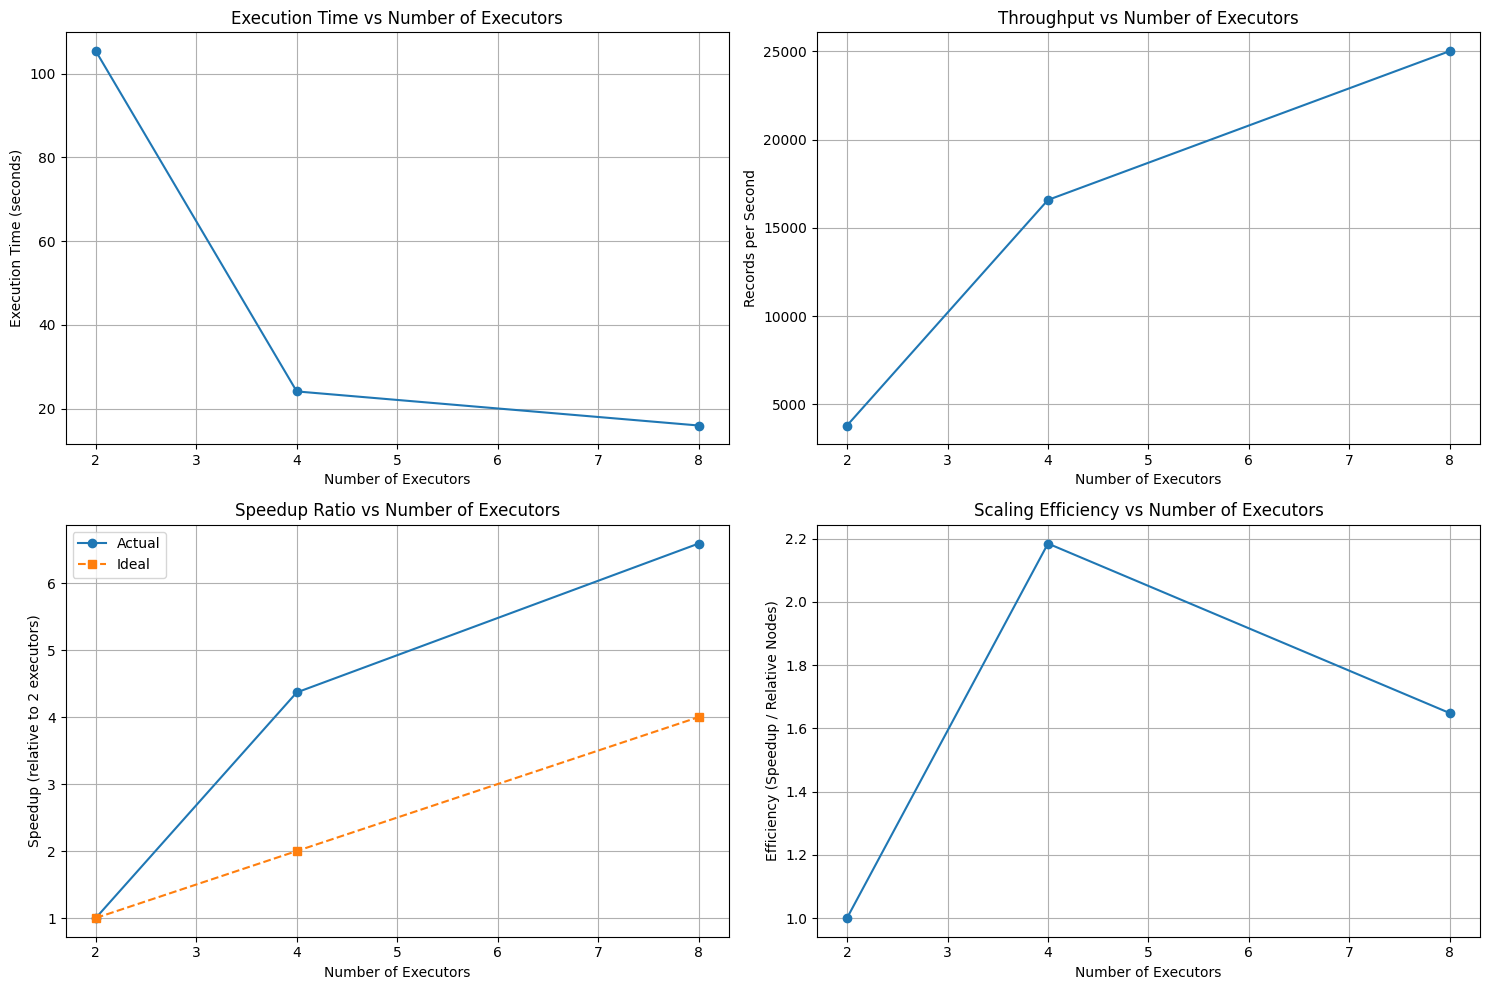

In [14]:
# Create visualizations
plt.figure(figsize=(15, 10))

# 1. Execution Time vs Number of Executors
plt.subplot(2, 2, 1)
plt.plot(results["num_executors"], results["execution_time"], marker='o', linestyle='-')
plt.title("Execution Time vs Number of Executors")
plt.xlabel("Number of Executors")
plt.ylabel("Execution Time (seconds)")
plt.grid(True)

# 2. Throughput (Records/second) vs Number of Executors
plt.subplot(2, 2, 2)
plt.plot(results["num_executors"], results["records_per_second"], marker='o', linestyle='-')
plt.title("Throughput vs Number of Executors")
plt.xlabel("Number of Executors")
plt.ylabel("Records per Second")
plt.grid(True)

# 3. Speedup Ratio (relative to 2 executors)
base_time = results["execution_time"][0]  # Time with 2 executors
speedup = [base_time / time for time in results["execution_time"]]
plt.subplot(2, 2, 3)
plt.plot(results["num_executors"], speedup, marker='o', linestyle='-', label="Actual")
ideal = [n/2 for n in results["num_executors"]]  # Ideal linear speedup
plt.plot(results["num_executors"], ideal, marker='s', linestyle='--', label="Ideal")
plt.title("Speedup Ratio vs Number of Executors")
plt.xlabel("Number of Executors")
plt.ylabel("Speedup (relative to 2 executors)")
plt.legend()
plt.grid(True)

# 4. Efficiency (Speedup / Number of Executors)
efficiency = [s / n for s, n in zip(speedup, [n/2 for n in results["num_executors"]])]
plt.subplot(2, 2, 4)
plt.plot(results["num_executors"], efficiency, marker='o', linestyle='-')
plt.title("Scaling Efficiency vs Number of Executors")
plt.xlabel("Number of Executors")
plt.ylabel("Efficiency (Speedup / Relative Nodes)")
plt.grid(True)

plt.tight_layout()
plt.savefig("node_scaling_experiment_results.png")
print("Charts saved to node_scaling_experiment_results.png")